## Assignment 1 (50 marks)
#### =====================================================================================================
### Deadline: 09/14 11:59 pm
#### =====================================================================================================

## Decision Tree Classification

### Problem 1 (25 marks)

`lab01_dataset_1.csv` contains a mixture of numerical and categorical data. Your task will be to write a function `my_ID3()` (without using the sklearn decision tree library) which can create a decision tree for the given dataset using the ID3 algorithm.

### 1.a (5 marks)

ID3 cannot handle continuous numerical data. Perform the necessary operations to convert the continuous-valued attribute to boolean attributes (refer to page 40 of Decision Tree.pdf). Do not use any of the sklearn library for this task. Display the updated dataset after handling continuous-valued attribute.

In [20]:
import pandas as pd
import math

def entropy(pos, neg):
    s = pos + neg
    if pos == 0 or neg == 0:
        return 0
    e = -((pos/s) * math.log2(pos/s)) - ((neg/s) * math.log2(neg/s))
    return e

def convert_continuous_to_bool(file, outdir): 
    df = pd.read_csv(file)
    df = df.sort_values(by=['Score']).reset_index(drop=True)
    n = len(df)
    pos = (df['Output'] == 'Yes').astype(int).sum()
    neg = n - pos    
    e = entropy(pos, neg)
    
    
    candidates = []
    for index, row in df.iterrows():
        if index == 0:
            continue
        if df.at[index-1, 'Output'] != row['Output']:
            candidates.append((df.at[index-1, 'Score'] + row['Score']) / 2)
    
    
    best_gain, c = -1, None
    for candidate in candidates:
        child = df['Score'] < candidate
        leafL, leafR = df[child], df[~child]
        
        child_pos = (leafL['Output'] == 'Yes').astype(int).sum()
        child_neg = len(leafL) - child_pos
    
        other_pos = (leafR['Output'] == 'Yes').astype(int).sum()
        other_neg = len(leafR) - other_pos
        
        gain = e - (len(leafL)/n) * entropy(child_pos, child_neg) - (len(leafR)/n) * entropy(other_pos, other_neg)
        if gain > best_gain:
            best_gain = gain
            c = candidate
            
    df[f'Score < {c}'] = df['Score'] < c
    print(f"Best threshold: {c}, Information Gain: {best_gain:.4f}")
    df = df.drop(columns=['Score'])
    
    if df.columns[-1] != 'Output':
        cols = [c for c in df.columns if c != 'Output'] + ['Output']
        df = df[cols]
        
    print(df)
    
    df.to_csv(outdir, index=False)
    
if __name__ == "__main__":
    convert_continuous_to_bool('lab01_dataset_1.csv', 'lab01_dataset_1_bool.csv')

Best threshold: 46.0, Information Gain: 0.3214
       Mood  Effort  Score < 46.0 Output
0     Happy     Low          True    Yes
1     Happy    High          True    Yes
2       Sad     Low          True    Yes
3     Happy     Low          True    Yes
4   Neutral  Medium         False     No
5   Neutral    High         False     No
6     Happy    High         False     No
7   Neutral    High         False     No
8     Happy     Low         False     No
9       Sad     Low         False     No
10      Sad  Medium         False    Yes
11      Sad    High         False    Yes
12  Neutral  Medium         False    Yes
13      Sad     Low         False    Yes
14  Neutral     Low         False     No
15    Happy  Medium         False     No
16    Happy  Medium         False     No
17      Sad    High         False     No
18      Sad  Medium         False     No


### 1.b (6 marks)

Next, you will have to ensure that the newly obtained dataset is optimal and free of errors. Take appropriate actions based on the outcomes of the following steps:

Check if the dataset has any missing values. (2 marks)<br>
Check if the dataset has any redundant or repeated input sample. (2 marks)<br>
Check if the dataset has any contradicting <input, output> pairs. (2 marks)

Do note that you need to perform all the above steps programmatically and not simply by visual examination.

In [21]:
def check_missing(df):
    return df.isna().sum().to_dict()

def find_redundant_inputs(df, target_col):
    feature_cols = [c for c in df.columns if c != target_col]
    dups_mask = df.duplicated(subset=feature_cols, keep=False)
    return df[dups_mask].sort_values(feature_cols)

def find_contradictions(df, target_col):
    feature_cols = [c for c in df.columns if c != target_col]
    g = df.groupby(feature_cols)[target_col].nunique()
    bad_keys = g[g > 1].index
    examples = []
    for key in bad_keys[:5]:
        subset = df[df[feature_cols].eq(pd.Series(key, index=feature_cols)).all(axis=1)]
        examples.append(subset)
    return len(bad_keys), examples

def compare_original_vs_bool(df_orig, df_bool, target_col):
    report = {}
    report["same_num_rows"] = (len(df_orig) == len(df_bool))
    report["same_targets_multiset"] = (sorted(df_orig[target_col].tolist()) == sorted(df_bool[target_col].tolist()))
    preserved_cols = [c for c in df_orig.columns if c != target_col]
    present_preserved = [c for c in preserved_cols if c in df_bool.columns]
    report["num_preserved_feature_cols_in_bool"] = len(present_preserved)
    report["preserved_feature_cols"] = present_preserved
    return report

def clean_redundant_exact_duplicates(df):
    before = len(df)
    df2 = df.drop_duplicates()
    return df2, before - len(df2)

def run_checks_and_fix():
    df_o = pd.read_csv('lab01_dataset_1.csv')
    target = df_o.columns[-1]
    df_b = pd.read_csv('lab01_dataset_1_bool.csv')

    print("=== Consistency: original vs boolean dataset ===")
    cmp_report = compare_original_vs_bool(df_o, df_b, target)
    for k, v in cmp_report.items():
        print(f"{k}: {v}")

    print("\n=== 1.b(i) Missing values in boolean dataset ===")
    miss = check_missing(df_b)
    print(miss)

    print("\n=== 1.b(ii) Redundant/repeated input samples (boolean dataset) ===")
    redundant = find_redundant_inputs(df_b, target_col=target)
    print(f"Count (by identical feature rows): {len(redundant)}")
    if len(redundant):
        display(redundant.head(10))

    print("\nAction: remove exact duplicate rows entirely (safe).")
    cleaned, removed = clean_redundant_exact_duplicates(df_b)
    print(f"Rows removed: {removed}")
    cleaned.to_csv('lab01_dataset_1_cleaned.csv', index=False)
    print(f"Saved cleaned boolean dataset to: {'lab01_dataset_1_cleaned.csv'}")

    print("\n=== 1.b(iii) Contradicting <input, output> pairs (boolean dataset, after de-dup) ===")
    n_groups, examples = find_contradictions(cleaned, target_col=target)
    print(f"Number of contradicting input groups: {n_groups}")
    if examples:
        print("Showing up to 5 example groups:")
        for ex in examples:
            display(ex)

if __name__ == "__main__":
    run_checks_and_fix()

=== Consistency: original vs boolean dataset ===
same_num_rows: True
same_targets_multiset: True
num_preserved_feature_cols_in_bool: 2
preserved_feature_cols: ['Mood', 'Effort']

=== 1.b(i) Missing values in boolean dataset ===
{'Mood': 0, 'Effort': 0, 'Score < 46.0': 0, 'Output': 0}

=== 1.b(ii) Redundant/repeated input samples (boolean dataset) ===
Count (by identical feature rows): 14


,Mood,Effort,Score < 46.0,Output
0,Happy,Low,True,Yes
3,Happy,Low,True,Yes
15,Happy,Medium,False,No
16,Happy,Medium,False,No
5,Neutral,High,False,No
7,Neutral,High,False,No
4,Neutral,Medium,False,No
12,Neutral,Medium,False,Yes
11,Sad,High,False,Yes
17,Sad,High,False,No



Action: remove exact duplicate rows entirely (safe).
Rows removed: 3
Saved cleaned boolean dataset to: lab01_dataset_1_cleaned.csv

=== 1.b(iii) Contradicting <input, output> pairs (boolean dataset, after de-dup) ===
Number of contradicting input groups: 4
Showing up to 5 example groups:


,Mood,Effort,Score < 46.0,Output
4,Neutral,Medium,False,No
12,Neutral,Medium,False,Yes


,Mood,Effort,Score < 46.0,Output
11,Sad,High,False,Yes
17,Sad,High,False,No


,Mood,Effort,Score < 46.0,Output
9,Sad,Low,False,No
13,Sad,Low,False,Yes


,Mood,Effort,Score < 46.0,Output
10,Sad,Medium,False,Yes
18,Sad,Medium,False,No


### 1.c (10 marks)

Your function `my_ID3()` should operate in a manner such that after ever round of decision making, it will output the attributes and its associated gain, with a message stating “Attribute X with Gain = Y is chosen as the decision attribute”. You can obviously create other functions as needed for completing `my_ID3()`.

In [22]:
def entropy(pos, neg):
    s = pos + neg
    if pos == 0 or neg == 0:
        return 0
    return -((pos/s) * math.log2(pos/s)) - ((neg/s) * math.log2(neg/s))

def majority_class(values):
    return max(set(values), key=lambda v: values.count(v))

def _count_pos_neg(labels, pos_label):
    pos = sum(1 for v in labels if v == pos_label)
    neg = len(labels) - pos
    return pos, neg

def info_gain(df, feature, target_col, pos_label):
    base_pos, base_neg = _count_pos_neg(df[target_col].tolist(), pos_label)
    base_entropy = entropy(base_pos, base_neg)

    conditional_entropy = 0.0
    total = len(df)
    for _, subset in df.groupby(feature):
        pos, neg = _count_pos_neg(subset[target_col].tolist(), pos_label)
        weight = len(subset) / total
        conditional_entropy += weight * entropy(pos, neg)

    return base_entropy - conditional_entropy

def my_id3(dataset, pos_label=None):
    df = dataset.copy()
    target_col = df.columns[-1]

    if pos_label is None:
        classes = list(df[target_col].unique())
        if len(classes) != 2:
            raise ValueError(f"ID3 here expects binary target; got {classes}")
        pos_label = 'Yes' if 'Yes' in classes else sorted(classes)[0]

    features = [c for c in df.columns if c != target_col]

    def build_tree(sub_df, sub_features, depth):
        if len(sub_df[target_col].unique()) == 1:
            return {"leaf": sub_df[target_col].iloc[0]}
        if not sub_features or sub_df.empty:
            return {"leaf": majority_class(list(sub_df[target_col]))}

        gains = {f: info_gain(sub_df, f, target_col, pos_label) for f in sub_features}
        best_feature = max(gains, key=gains.get)
        print("  " * depth + f"Choose '{best_feature}' (IG={gains[best_feature]:.4f}) from {list(sub_features)}")

        node = {"attr": best_feature, "children": {}}
        for value, subset in sub_df.groupby(best_feature):
            if subset.empty:
                node["children"][value] = {"leaf": majority_class(list(sub_df[target_col]))}
            else:
                remaining = [f for f in sub_features if f != best_feature]
                node["children"][value] = build_tree(subset.drop(columns=[best_feature]), remaining, depth + 1)
        return node
    return build_tree(df, features, 0)

if __name__ == "__main__":
    df_input = pd.read_csv("lab01_dataset_1_cleaned.csv")
    tree = my_id3(df_input)

Choose 'Score < 46.0' (IG=0.2652) from ['Mood', 'Effort', 'Score < 46.0']
  Choose 'Mood' (IG=0.1793) from ['Mood', 'Effort']
    Choose 'Effort' (IG=0.3113) from ['Effort']
    Choose 'Effort' (IG=0.0000) from ['Effort']


### 1.d (4 marks)

Display the decision tree. The representation of the decision tree is upto you. You can choose either a textual representation or a graphical one; either is fine.

In [23]:
def print_tree(node, depth=0):
    if "leaf" in node:
        print("  " * depth + f"[Leaf] -> {node['leaf']}")
    else:
        print("  " * depth + f"[Split on '{node['attr']}']")
        for value, child in node["children"].items():
            print("  " * (depth + 1) + f"= {value}:")
            print_tree(child, depth + 2)

if __name__ == "__main__":

    print_tree(tree)

[Split on 'Score < 46.0']
  = False:
    [Split on 'Mood']
      = Happy:
        [Leaf] -> No
      = Neutral:
        [Split on 'Effort']
          = High:
            [Leaf] -> No
          = Low:
            [Leaf] -> No
          = Medium:
            [Leaf] -> Yes
      = Sad:
        [Split on 'Effort']
          = High:
            [Leaf] -> Yes
          = Low:
            [Leaf] -> Yes
          = Medium:
            [Leaf] -> Yes
  = True:
    [Leaf] -> Yes


### Problem 2 (25 marks)

`lab01_dataset_2.csv` has a mixture of numerical and categorical data. For this problem, you will use sklearn's [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for the classification task.

### 2.a (5 marks)

Encode all the categorial data into numerical data using `One-hot Encoding` and display the new dataset.

In [32]:
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv("lab01_dataset_2.csv")
target_col = "Output"
X = df.drop(columns=[target_col])
y = df[target_col]

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.columns.difference(cat_cols).tolist()

enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

enc.fit(X[cat_cols])

feature_names = enc.get_feature_names_out(cat_cols)

X_cat_ohe = enc.transform(X[cat_cols])
X_cat_ohe_df = pd.DataFrame(X_cat_ohe, columns=feature_names, index=X.index)

X_encoded = pd.concat([X[num_cols], X_cat_ohe_df], axis=1)
print("\nEncoded shape:", X_encoded.shape)
print(X_encoded.head())
X_encoded.to_csv("lab01_dataset_2_encoded.csv", index=False)


Encoded shape: (200, 9)
   Age  Na_to_K  Sex_F  Sex_M  BP_HIGH  BP_LOW  BP_NORMAL  Cholesterol_HIGH  \
0   23   25.355    1.0    0.0      1.0     0.0        0.0               1.0   
1   47   13.093    0.0    1.0      0.0     1.0        0.0               1.0   
2   47   10.114    0.0    1.0      0.0     1.0        0.0               1.0   
3   28    7.798    1.0    0.0      0.0     0.0        1.0               1.0   
4   61   18.043    1.0    0.0      0.0     1.0        0.0               1.0   

   Cholesterol_NORMAL  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  


### 2.b (10 marks)

Using the encoded dataset, perform the supervised learning using [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Employ the [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) of 80-20 during the training.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=0, stratify=y
)

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)
print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Train accuracy:", clf.score(X_train, y_train))
print("Test accuracy:", clf.score(X_test, y_test))

Train size: (160, 9)  Test size: (40, 9)
Train accuracy: 1.0
Test accuracy: 0.975


### 2.c (5 marks)

After the training is complete, show the results by predicting the class of the test set. Display the results of the prediction and test set side-by-side.

In [33]:
y_pred = clf.predict(X_test)
comparison = pd.DataFrame({"Actual": y_test.reset_index(drop=True), "Predicted": y_pred})
print(comparison.head(20))

   Actual Predicted
0   drugC     drugC
1   drugX     drugX
2   drugA     drugA
3   drugX     drugX
4   drugY     drugY
5   drugY     drugY
6   drugY     drugY
7   drugY     drugY
8   drugY     drugY
9   drugY     drugY
10  drugA     drugA
11  drugY     drugY
12  drugC     drugC
13  drugY     drugY
14  drugX     drugX
15  drugB     drugB
16  drugC     drugC
17  drugX     drugX
18  drugY     drugY
19  drugA     drugA


### 2.d (5 marks)

Display the decision tree; it can be either a textual representation or a graphical representation.

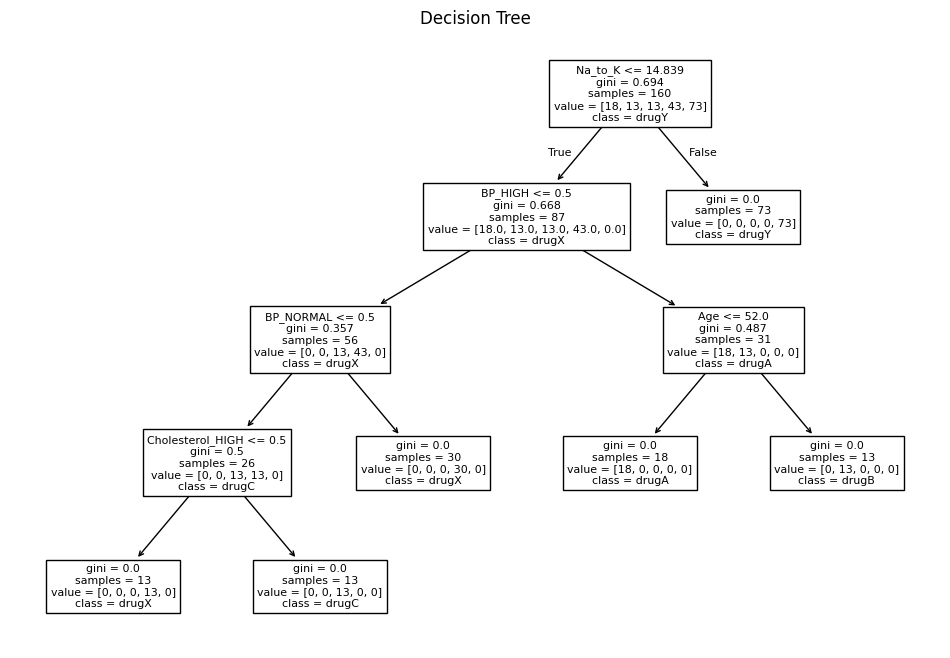

In [30]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text

plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=list(X_encoded.columns), class_names=sorted(y.unique()), filled=False)
plt.title("Decision Tree")
plt.show()